# Seminar 1. MCMC algorithms
Distributions: Funnel, Banana, Mixture of Gaussians

Methods: ULA, MALA, ISIR, HMC (pyro), Tempered Transitions (Neal)

In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 25.8 MB/s 


In [ ]:
import copy
from typing import Optional, List, Tuple, Iterable, Callable
from functools import partial
from tqdm import tqdm, trange

import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Cauchy, Categorical
from matplotlib import pyplot as plt
import seaborn as sns
import pyro
from pyro.infer import MCMC, HMC, NUTS
from scipy.stats import gaussian_kde

sns.set_theme('talk', style="white")

In [ ]:
N_CHAINS = 25
N_SAMPLES = 1000
BURN_IN = 100

PROJ_DIM1 = -2
PROJ_DIM2 = -1

First representative - mixture of Gaussians. Multimodal, simple geometry.

In [ ]:
class MoG(object):
    """
    Mixture of Gaussians distribution.

    Args:
        locs - locations of mean parameters for each Gaussian
        covs - covariances for each Gaussian
    """
    def __init__(self, 
            locs: torch.FloatTensor, 
            covs: torch.FloatTensor, 
            weights: Optional[torch.FloatTensor]=None):
        self.n_comp = len(locs)
        self.locs = locs
        self.covs = covs
        self.weights = weights if weights is not None else \
            torch.ones(self.n_comp, device=locs.device)
        self.weights /= self.weights.sum()
        self.gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]

    @property
    def dim(self) -> int:
        return self.locs.shape[-1]

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(x) for weight, gauss in zip(self.weights, self.gaussians)
            ], dim=0)
        return torch.logsumexp(log_ps, dim=0)

    def plot_2d_countour(self, ax):
        rad = self.covs.max() **.5 * 5
        x = np.linspace(self.locs.min()-rad, self.locs.max()+rad, 100)
        y = np.linspace(self.locs.min()-rad, self.locs.max()+rad, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.FloatTensor(np.stack([X, Y], -1))

        proj_slice = [PROJ_DIM1, PROJ_DIM2]
        gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(self.locs, self.covs)]
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(self.weights, gaussians)
            ], dim=0)
        Z = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=10, 
                   alpha=1., cmap='inferno')

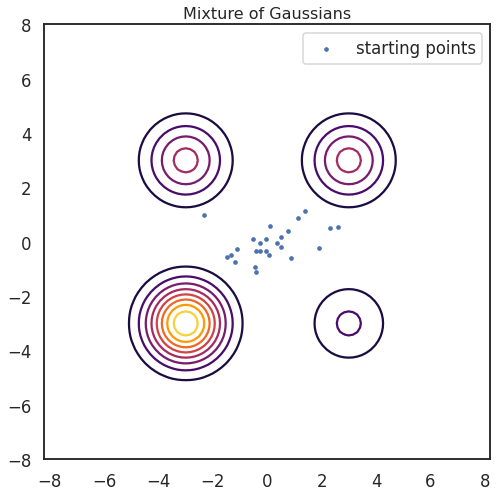

In [ ]:
dim = 2
center_pts = 6*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)

plt.figure(figsize = (8,8))
ax = plt.subplot()
mog.plot_2d_countour(ax)


start_mog = torch.randn((N_CHAINS, mog.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_mog[:, proj_slice].T, s=10, label='starting points')
plt.title('Mixture of Gaussians', fontsize = 16)
plt.axis('equal')
plt.legend()
plt.show()


$f(x_1, x_2, \cdots, x_d) = \left[\prod\limits_{i=1}^{d-1} \mathcal{N}(x_i \mid 0, e^{x_d / 2}) \right] \times \mathcal{N}(x_d \mid 0, a)$

“Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

Next example: $d$-dimensional Funnel distribution. Note that it allows for the reparametrisation, that allows for exact sampling. The  corresponding density function:
$$
p_{f}(x) = \operatorname{Z}^{-1} \exp\left(- x_d^2/2a^2 - (1/2) e^{-x_d} \sum\nolimits_{i=1}^{d-1}\{x_i^2 + x_1\}\right)\,, \quad d \geq 2,
$$
Note that we have a doule exponent in the density...

In [ ]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        normal_first = Normal(torch.zeros(x.shape[:-1]), torch.exp(x[..., -1] / 2.))
        return normal_first.log_prob(x[..., :-1].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., -1])

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-7, 7, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=7, 
                   alpha=1., cmap='inferno')

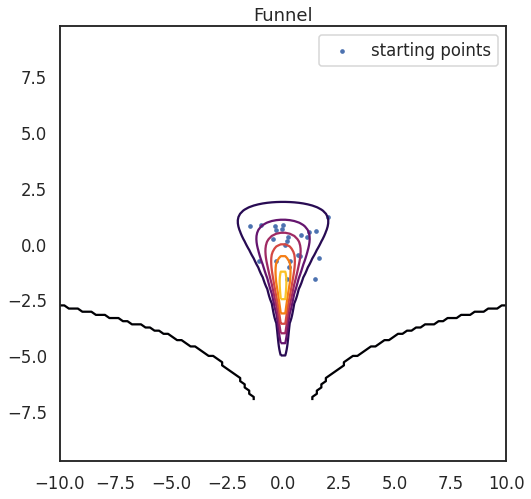

In [ ]:
#default parameter
funnel_a = 2
dim_f = 10

funnel = Funnel(dim_f, funnel_a)
plt.figure(figsize = (8,8))
ax = plt.subplot()
funnel.plot_2d_countour(ax)

start_funnel = torch.randn((N_CHAINS, funnel.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_funnel[:, proj_slice].T, s=10, label='starting points')
plt.title('Funnel')
plt.legend()
plt.axis('equal')
plt.show()

Generate funnel with explicit reparametrization

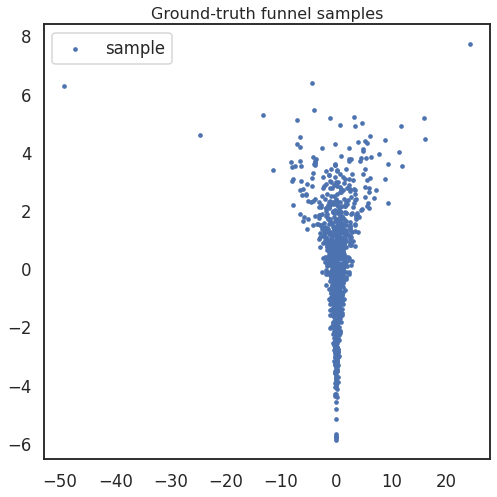

In [ ]:
N_samples = 1*10**3
np.random.seed(42)
True_samples_f = np.random.randn(N_samples,dim)
True_samples_f[:,-1] *= funnel_a 
for k in range(dim-1):
    True_samples_f[:,k] *= np.exp(True_samples_f[:,-1]/2) 
#visualize funnel  
plt.figure(figsize = (8,8))
ax = plt.subplot()

proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(True_samples_f[:, -2],True_samples_f[:, -1], s=10, label='sample')
plt.title('Ground-truth funnel samples', fontsize = 16)
#plt.axis('equal')
plt.legend()
plt.show()

Next potential - Banana-shape distribution. It has somehow simpler geometry, compared to the Funnel. The density function:
$$
p_{b}(x) = Z^{-1} \exp\left(- \sum\nolimits_{i=1}^{d/2}\bigl\{x_{2i}^2/2a^2 - (x_{2i-1} - bx_{2i}^{2} + a^2 b)^{2}/2 \bigr\}\right)\,, \quad d = 2k, k \in \mathbb{N}
$$

In [ ]:
class Banana(object):
    """
    """
    def __init__(self, dim: int, b: float, sigma: float):
        #self.q = q
        self.b = b
        self.sigma = sigma
        self._dim = dim
        #self.normal_even = Normal(1, 1)
        #self.normal_odd = Normal(0, q)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5*(x[..., odd] - self.b*x[..., even]**2 + (self.sigma**2)*self.b)**2 - ((x[..., even])**2)/(2*self.sigma**2)
        return ll.sum(-1)

        #return self.normal_even.log_prob(x[..., even]).sum(-1) + \
        #    self.normal_odd.log_prob(x[..., even] - x[..., odd] ** 2).sum(-1)

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=5,
                   alpha=1., cmap='inferno')

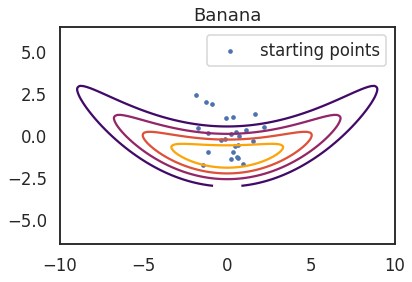

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 10

banana = Banana(dim_b, banana_b, sigma_b)
ax = plt.subplot()
banana.plot_2d_countour(ax)

start_banana = torch.randn((N_CHAINS, banana.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_banana[:, proj_slice].T, s=10, label='starting points')
plt.title('Banana')
plt.legend()
plt.axis('equal')
plt.show()

Ground-truth samples from the banana-shape distibution with explicit reparametrization:


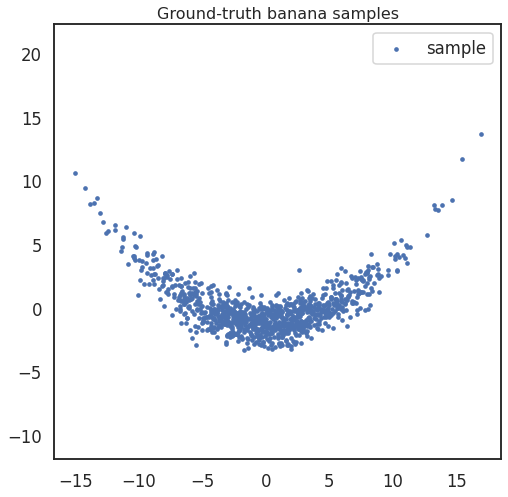

In [ ]:
N_samples = 10**3
np.random.seed(42)
True_samples_banana = np.random.randn(N_samples,dim_b)
for i in range(dim_b):
    if i % 2 == 0:
      True_samples_banana[:,i] *= sigma_b
    else:
      True_samples_banana[:,i] += banana_b*True_samples_banana[:,i-1]**2 - (sigma_b**2)*banana_b
#visualize banana  
plt.figure(figsize = (8,8))
ax = plt.subplot()
#mog.plot_2d_countour(ax)

#start_mog = torch.randn((N_CHAINS, mog.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(True_samples_banana[:, -2],True_samples_banana[:, -1], s=10, label='sample')
plt.title('Ground-truth banana samples', fontsize = 16)
plt.axis('equal')
plt.legend()
plt.show()

Utils to visualize samples

In [ ]:
# some code for drawing

def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(chains, dist, chain_id=0):
    proj_slice = [PROJ_DIM1, PROJ_DIM2]
    proj_dim1 = dist.dim + PROJ_DIM1 + 1 if PROJ_DIM1 < 0 else PROJ_DIM1 + 1
    proj_dim2 = dist.dim + PROJ_DIM2 + 1 if PROJ_DIM2 < 0 else PROJ_DIM2 + 1

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0,0])
    xmin, xmax = axs[0,0].get_xlim()
    ymin, ymax = axs[0,0].get_ylim()

    axs[0,0].scatter(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]), s=10)
    axs[0,0].set_title(f'Projected samples from {N_CHAINS} chains')

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[0,1].contour(X, Y, kde, cmap='inferno')
    axs[0,1].set_title(f'KDE')

    chain_id = 0
    result = chains[:, chain_id, :]
    dist.plot_2d_countour(axs[1,0])
    axs[1,0].scatter(*result[:, proj_slice].T, s = 10)
    axs[1,0].set_title(f'Trajectory of chain {chain_id}')

    if len(np.unique(result[:, proj_slice], axis=0)) > 0:
      try:
        kernel = gaussian_kde(np.unique(result[:, proj_slice], axis=0).T)
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[1,1].contour(X, Y, kde, cmap='inferno')
        axs[1,1].set_title(f'KDE')
      except numpy.linalg.LinAlgError:
        pass


    for i in range(2):
      for j in range(2):
        axs[i,j].set_xlim(xmin, xmax)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_xlabel(fr'$X{proj_dim1}$')
        axs[i,j].set_ylabel(fr'$X{proj_dim2}$')
        # ax.axis('square')

    fig.tight_layout()
    plt.show()

In [ ]:
def ISIR(start: torch.FloatTensor, 
        target,
        proposal, 
        n_samples: int,
        burn_in: int, 
        *, 
        n_particles: int, 
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()
        
        x = particles[np.arange(x.shape[0]), indices]
        logp_x = logps[np.arange(x.shape[0]), indices]
        logq_x = logqs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)        
    return chains, acceptance_rate

Start with gaussian mixture at dimension $d = 2$. Let us gradually increase the variance of the proposal

In [ ]:
#create potential (mixture of gaussians)
dim = 10
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

proposal_scale = 3. #try 1,3,5
n_particles = 1000
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)

chains, acceptance_rates = ISIR(start_mog, mog, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:16<00:00, 65.11it/s]


Text(0.5, 0, 'Iteration')

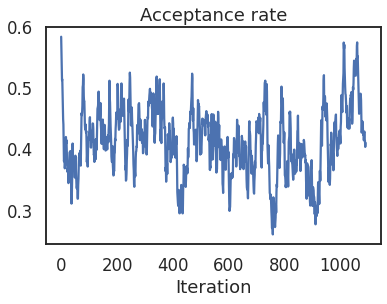

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
plot_result(chains, mog)

Well, in $d = 2$ everything works fine. Let us try to increase dimension a bit

In [ ]:
#create potential (mixture of gaussians)
dim = 40
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

proposal_scale = 3. 
n_particles = 1000 #try 10, 100, 1000
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)

chains, acceptance_rates = ISIR(start_mog, mog, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:43<00:00, 25.19it/s]


Text(0.5, 0, 'Iteration')

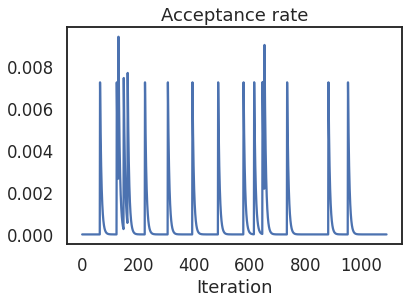

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

/usr/local/lib/python3.7/dist-packages/scipy/stats/kde.py:576: RuntimeWarning: Degrees of freedom <= 0 for slice
  aweights=self.weights))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


NameError: ignored

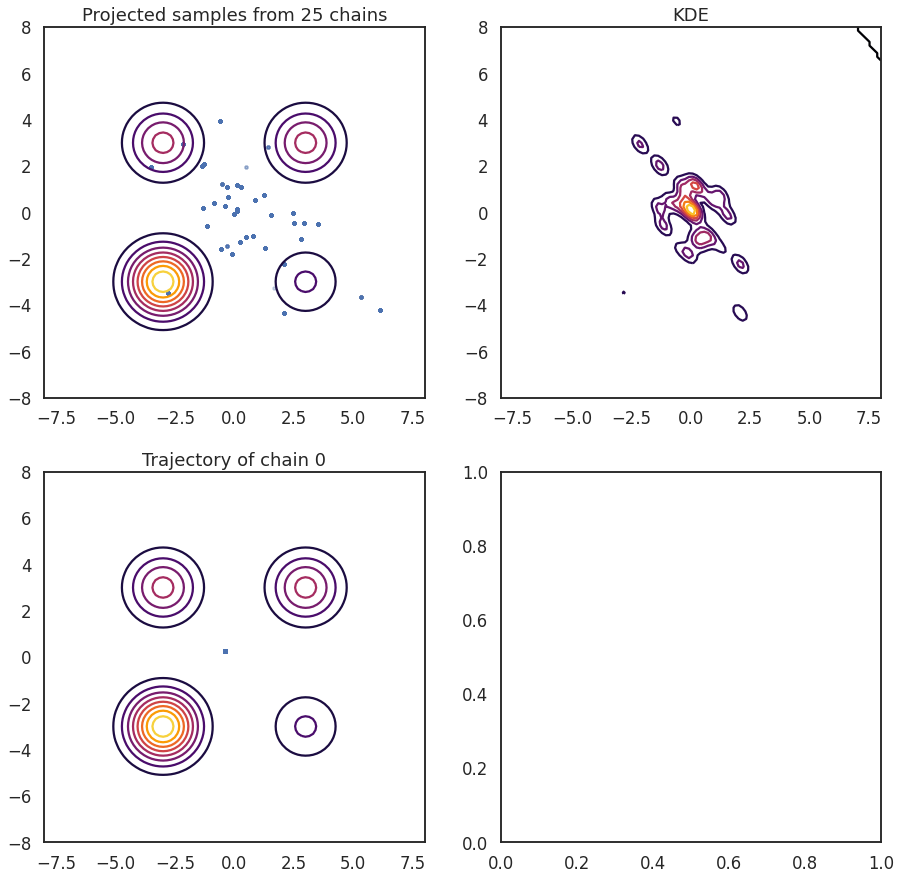

In [ ]:
plot_result(chains, mog)

Let us now try to take $d = 20$ and keep the same number of proposals. As you can see, we are still dead. So for i-SIR, as for rejection sampling, it is extremely important to tune proposals carefully. Let us now try the banana-shaped distribution.

In [ ]:
n_particles = 100
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)

proposal_covs = torch.ones(banana.dim)
even = np.arange(0, banana.dim, 2)
odd = np.arange(1, banana.dim, 2)
proposal_covs[even] *= sigma_b
proposal_covs[odd]*= (sigma_b**2)*banana_b*np.sqrt(2)
proposal_covs = torch.diag(proposal_covs)
#proposal distribution
proposal = MNormal(torch.zeros(banana.dim), proposal_covs)
#start points
start_banana = torch.randn((N_CHAINS, banana.dim))
chains, acceptance_rates = ISIR(start_banana, banana, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:02<00:00, 503.54it/s]


Text(0.5, 0, 'Iteration')

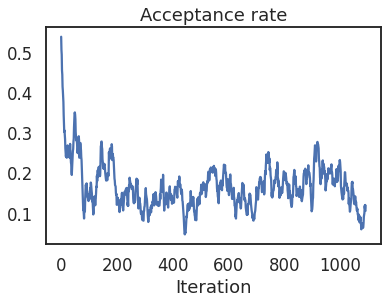

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

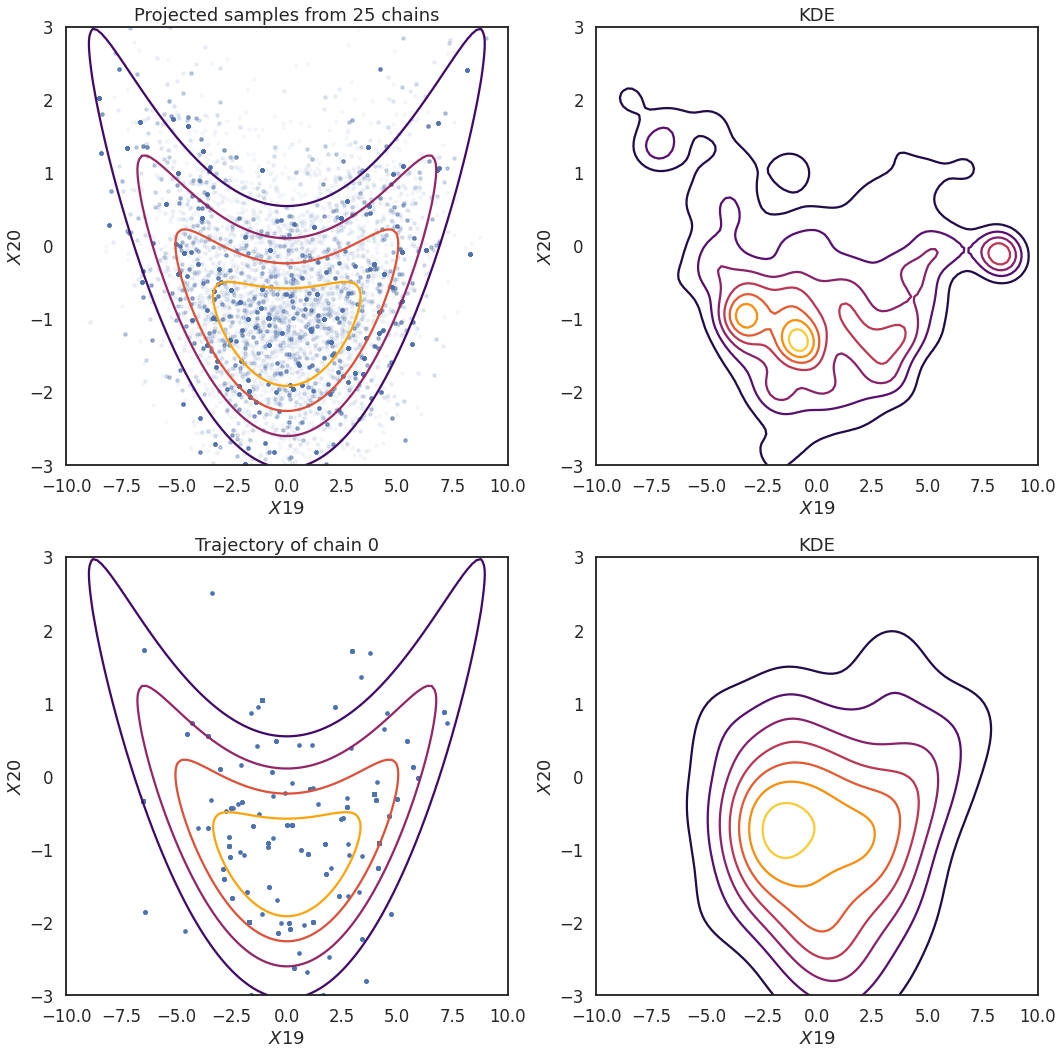

In [ ]:
plot_result(chains, banana)

Let us now switch to graadient-based MCMC. We begin with Unadjusted and Metropolis-adjusted langevin algorithms

In [ ]:
def ULA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> torch.FloatTensor:
    """
    Unadjusted Langevin Algorithm
    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim]
    """
    chains = []
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    
    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        log_prob = target.log_prob(x)
        grad = torch.autograd.grad(log_prob.sum(), x)[0]
        x = x + step_size * grad + (2 * step_size) ** .5 * torch.randn_like(x)
        
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains

In [ ]:
def MALA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1]), torch.eye(start.shape[-1]))
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)
        
        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
dim = 2
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#tune step-size
step_size =  1.0 #try different ones: 0.05, 0.5, 1.0
chains = ULA(start_mog, mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 771.69it/s]


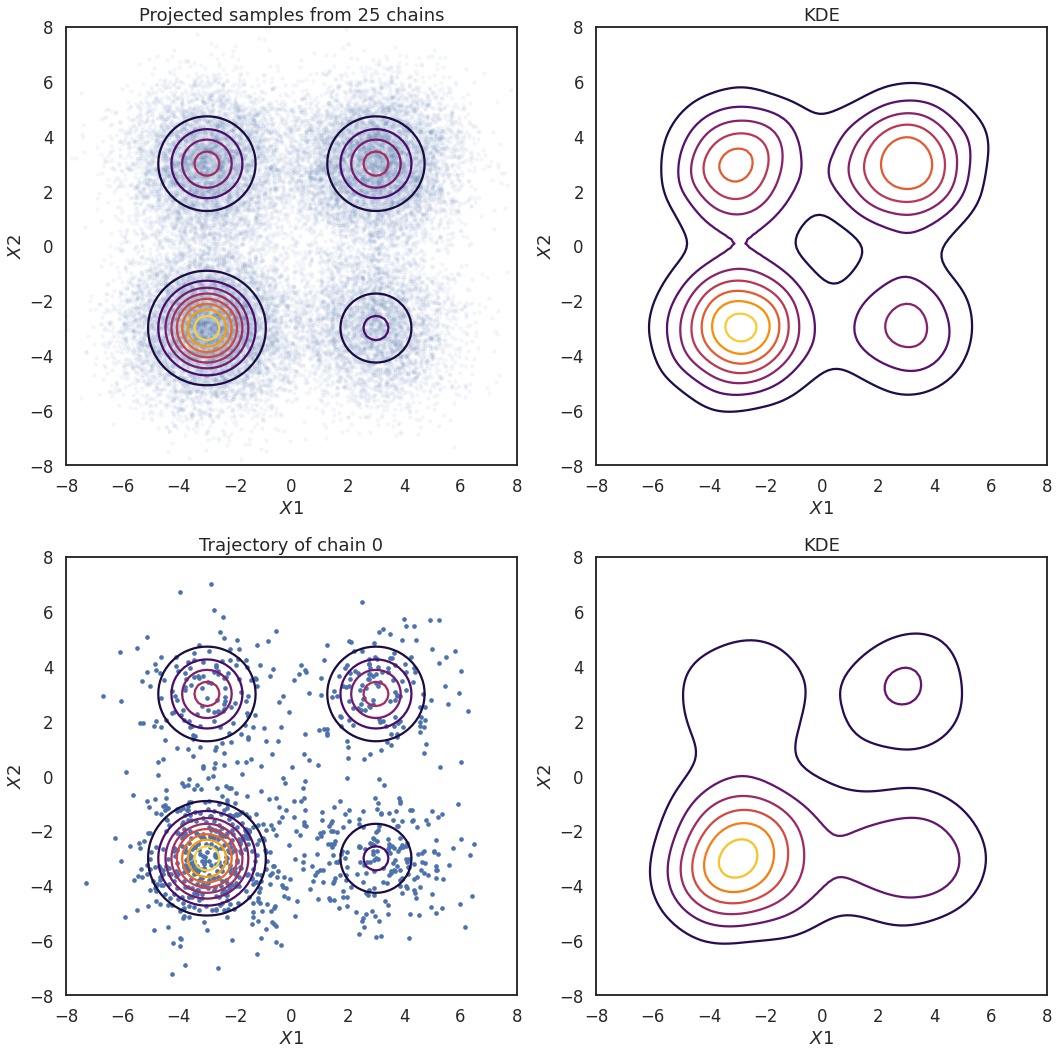

In [ ]:
plot_result(chains, mog)

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)

#step size
step_size = 0.5 #try different ones: 0.05, 0.25, 1.0. For small step size try different sample sizes
chains = ULA(start_banana, banana, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:00<00:00, 2694.69it/s]


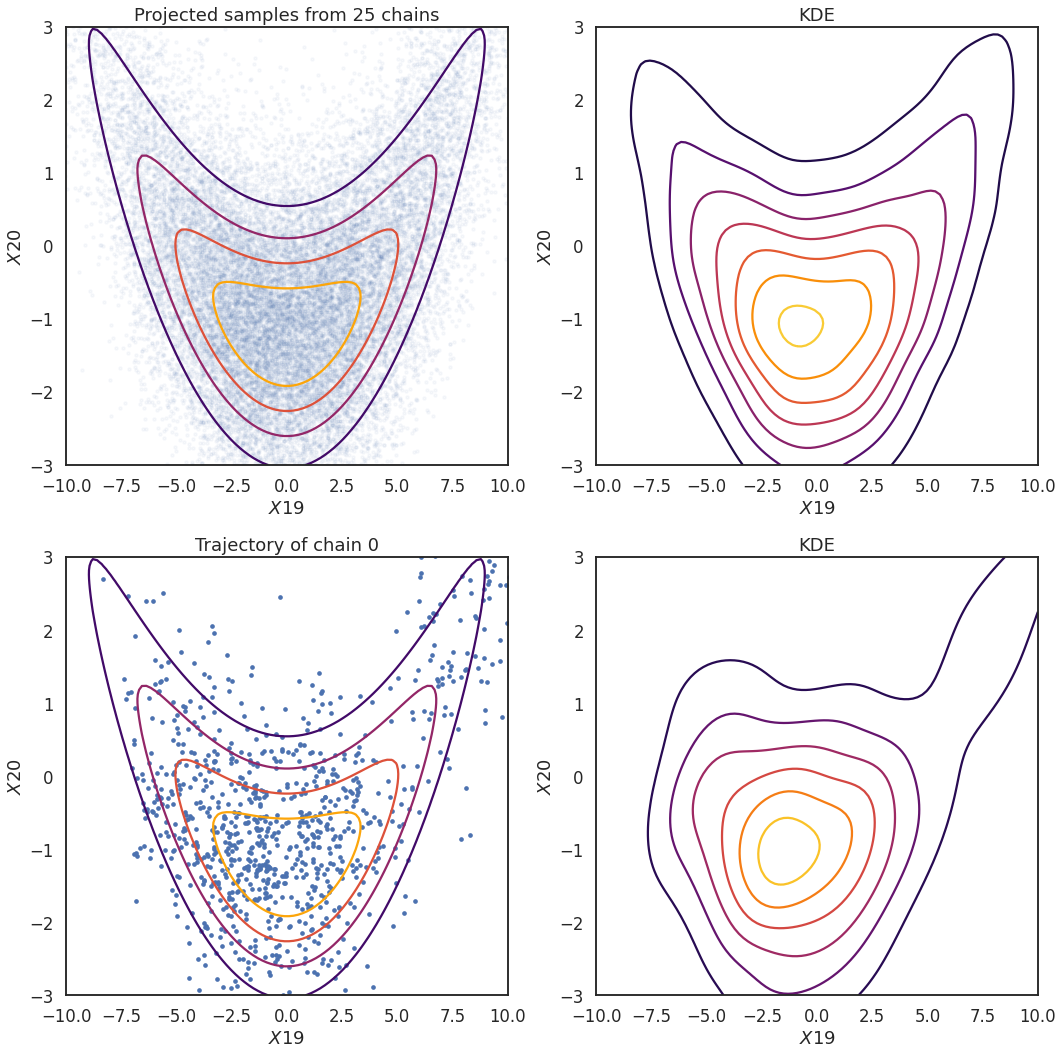

In [ ]:
plot_result(chains, banana)

In [ ]:
funnel_a = 2
dim_f = 20

funnel = Funnel(dim_f, funnel_a)
step_size = 0.2 #try different step sizes: 0.01, 0.1, 0.2 
chains = ULA(start_funnel, funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:00<00:00, 1697.01it/s]


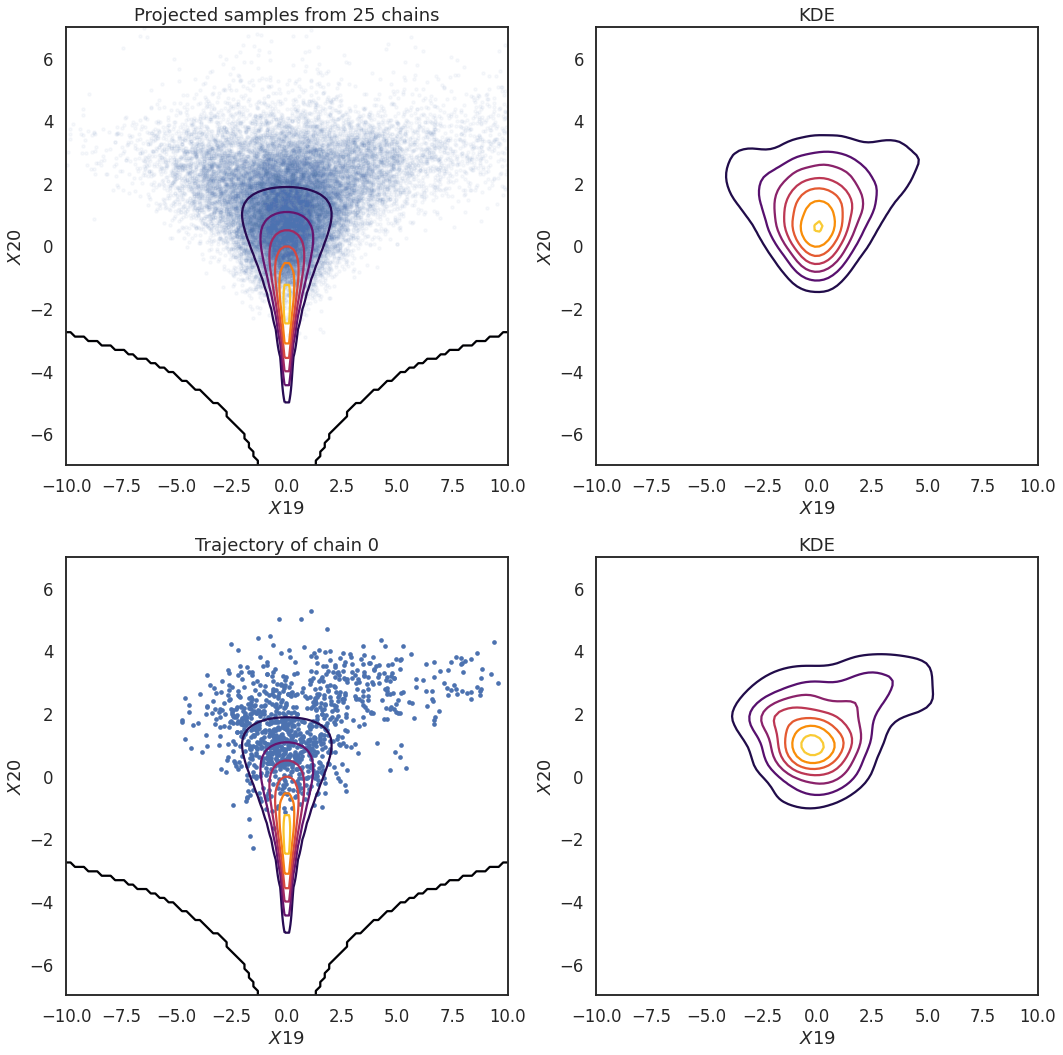

In [ ]:
plot_result(chains, funnel)

As far as we have seen, ULA is not super good in sampling multimodal and highly-nonlinear densities. Let us try its corrected version (MALA).

In [ ]:
dim = 10
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#tune step-size
step_size = 2 #try different ones: 0.05, 0.5, 1.0, 2.0

chains, acceptance_rates = MALA(start_mog, mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 571.28it/s]


Text(0.5, 0, 'Iteration')

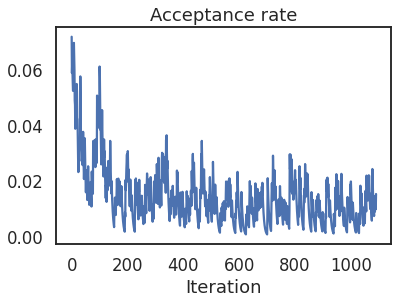

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

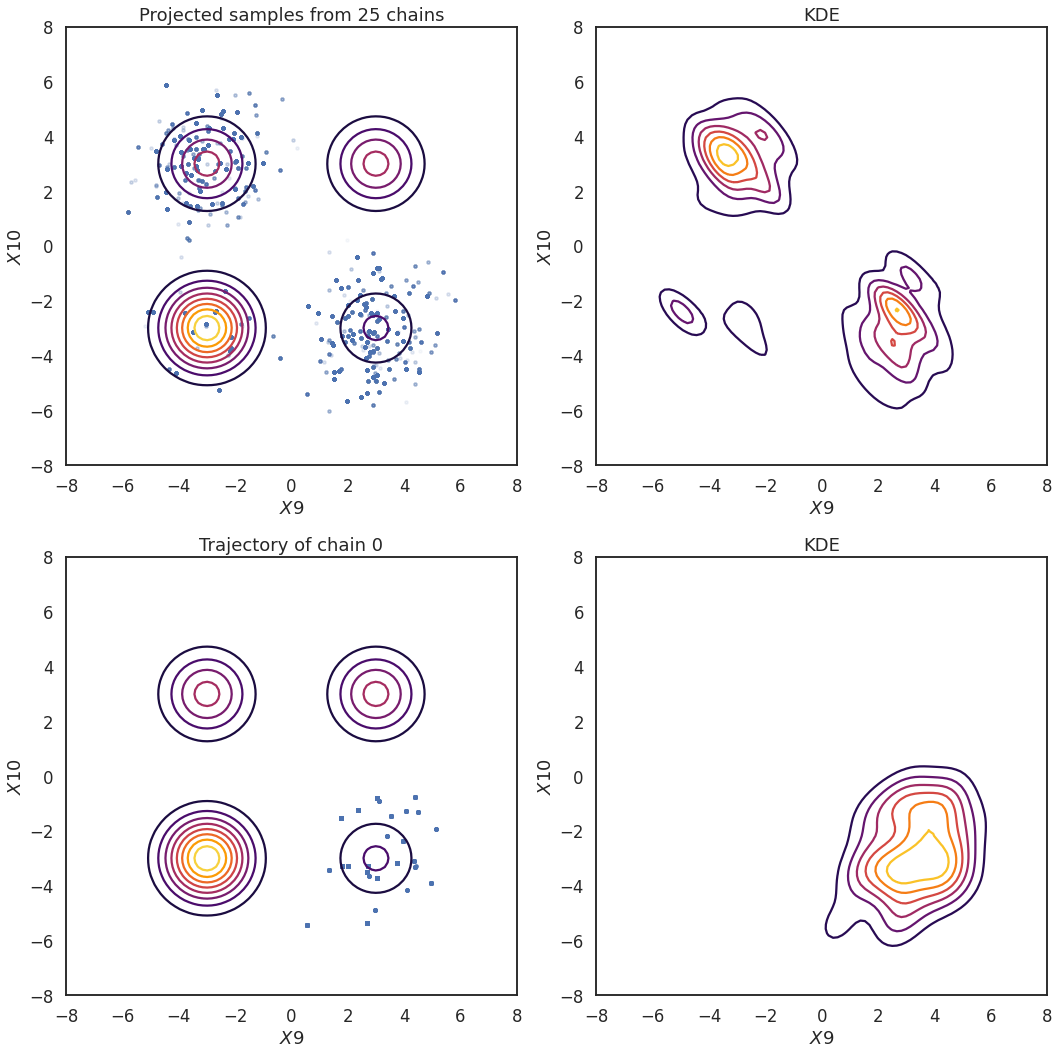

In [ ]:
plot_result(chains, mog)

Optimal acceptance rate for MALA is known to be $~0.234$. Typically values between $0.2$ and $0.5$ are good.

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)

#tune step-size
step_size = 1.0 #try different ones: 0.05, 0.25, 1.0

chains, acceptance_rates = MALA(start_banana, banana, 5*N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 5100/5100 [00:04<00:00, 1103.79it/s]


Text(0.5, 0, 'Iteration')

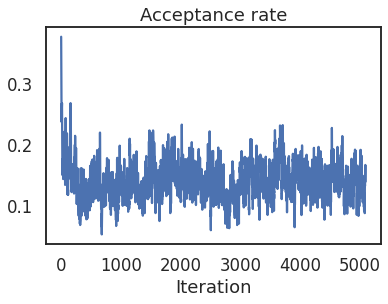

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

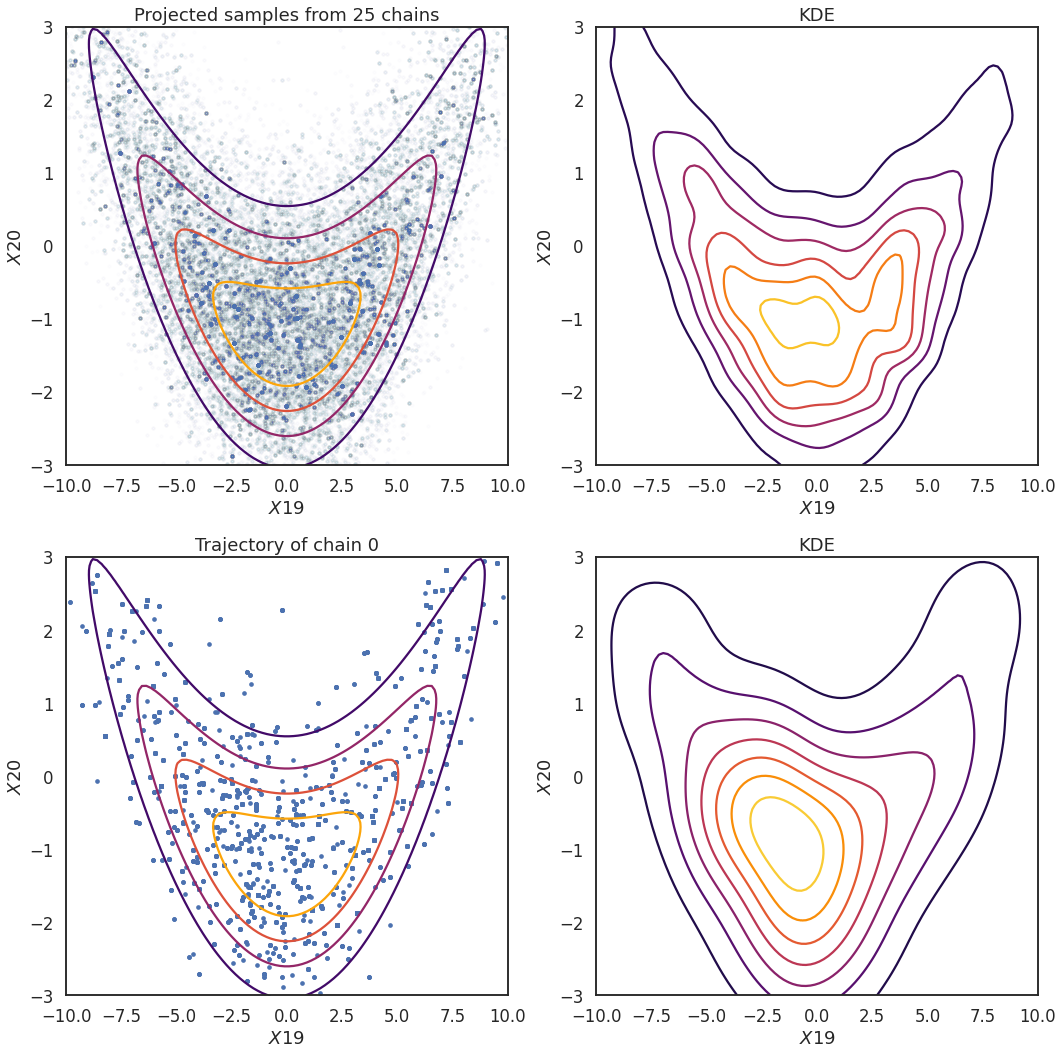

In [ ]:
plot_result(chains, banana)

In [ ]:
funnel_a = 2
dim_f = 20

funnel = Funnel(dim_f, funnel_a)
step_size = 0.5 #try different step sizes: 0.01, 0.1, 0.5 

chains, acceptance_rates = MALA(start_funnel, funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 894.36it/s]


Text(0.5, 0, 'Iteration')

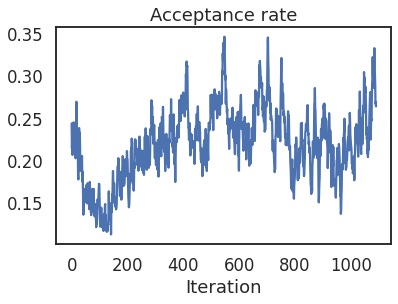

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

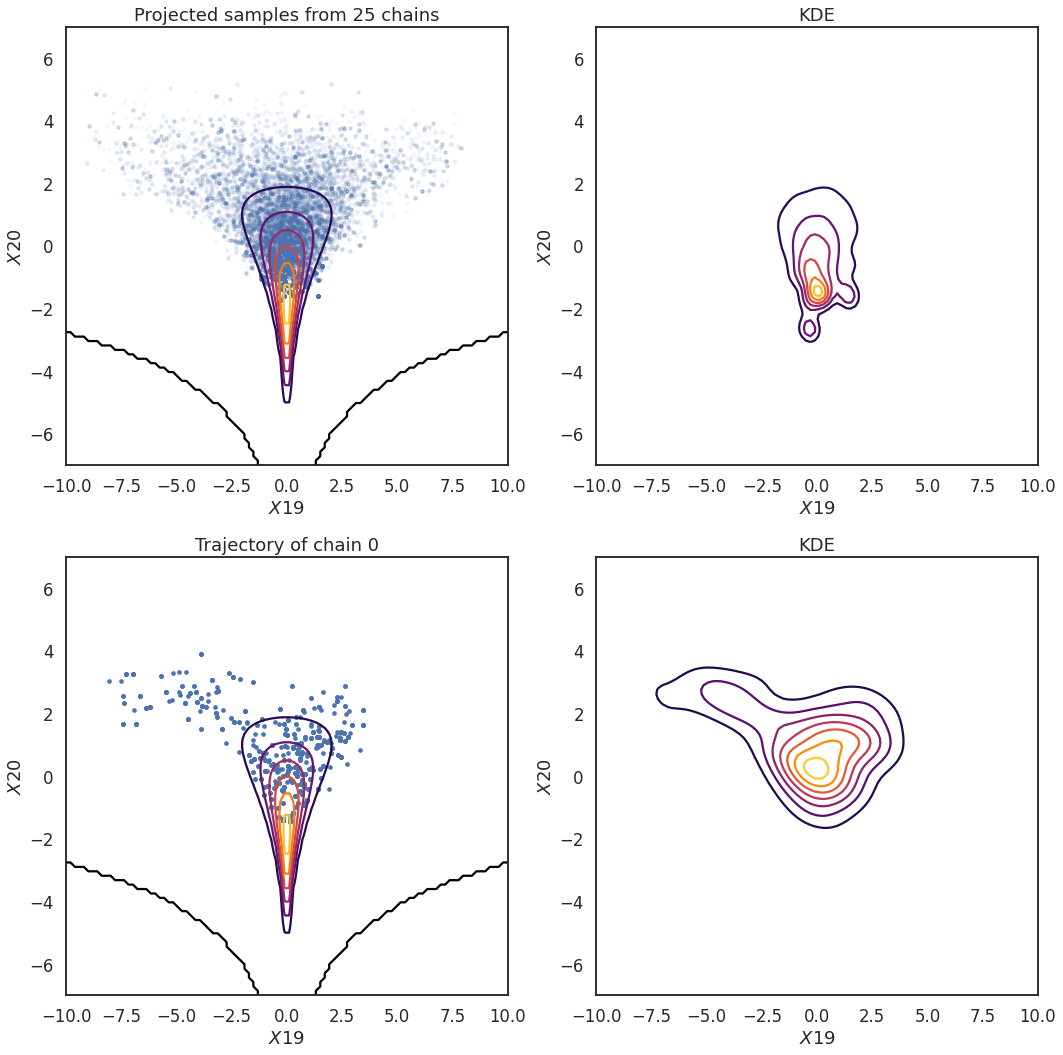

In [ ]:
plot_result(chains, funnel)

Now let us try combining local and global moves, that is, Ex$^2$MCMC algorithm.

In [ ]:
def Ex2MCMC(start: torch.FloatTensor, 
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float,
        n_particles: int, 
        n_mala_steps: int = 1,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Ex2MCMC

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_particles - number of particles including one from previous step
        n_mala_steps - number of MALA steps after each SIR step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = log_ps - log_qs
        indices = Categorical(logits=log_weights).sample()
        x = particles[np.arange(x.shape[0]), indices]

        if n_mala_steps > 0:
            xs, acc = MALA(x, target, n_mala_steps, 0, step_size=step_size)
            x = xs[-1]
            logp_x = target.log_prob(x)
            logq_x = proposal.log_prob(x)
        else:
            logp_x = log_ps[np.arange(x.shape[0]), indices]
            logq_x = log_qs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
dim = 20
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

step_size = 0.25
proposal_scale = 2.0
n_particles = 100
n_mala_steps = 3
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)


chains, acceptance_rates = Ex2MCMC(start_mog, mog, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:13<00:00, 82.78it/s]


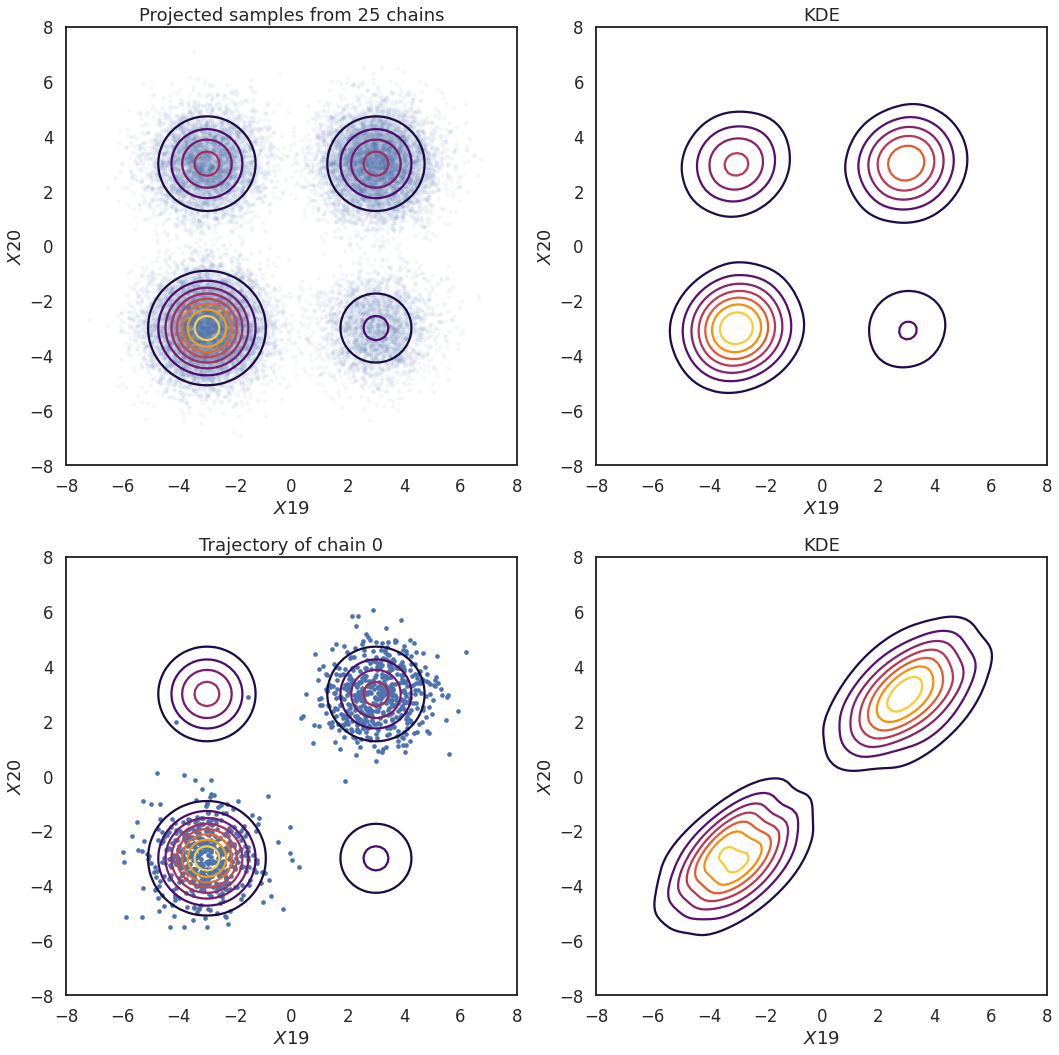

In [ ]:
plot_result(chains, mog)

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)
start_banana = torch.randn((N_CHAINS, banana.dim))

step_size = 0.25
n_particles = 20
n_mala_steps = 3

#proposal parameters
proposal_covs = torch.ones(banana.dim)
even = np.arange(0, banana.dim, 2)
odd = np.arange(1, banana.dim, 2)
proposal_covs[even] *= sigma_b
proposal_covs[odd]*= (sigma_b**2)*banana_b*np.sqrt(2)
proposal_covs = torch.diag(proposal_covs)
#proposal distribution
proposal = MNormal(torch.zeros(banana.dim), proposal_covs)

chains, acceptance_rates = Ex2MCMC(start_banana, banana, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:05<00:00, 218.80it/s]


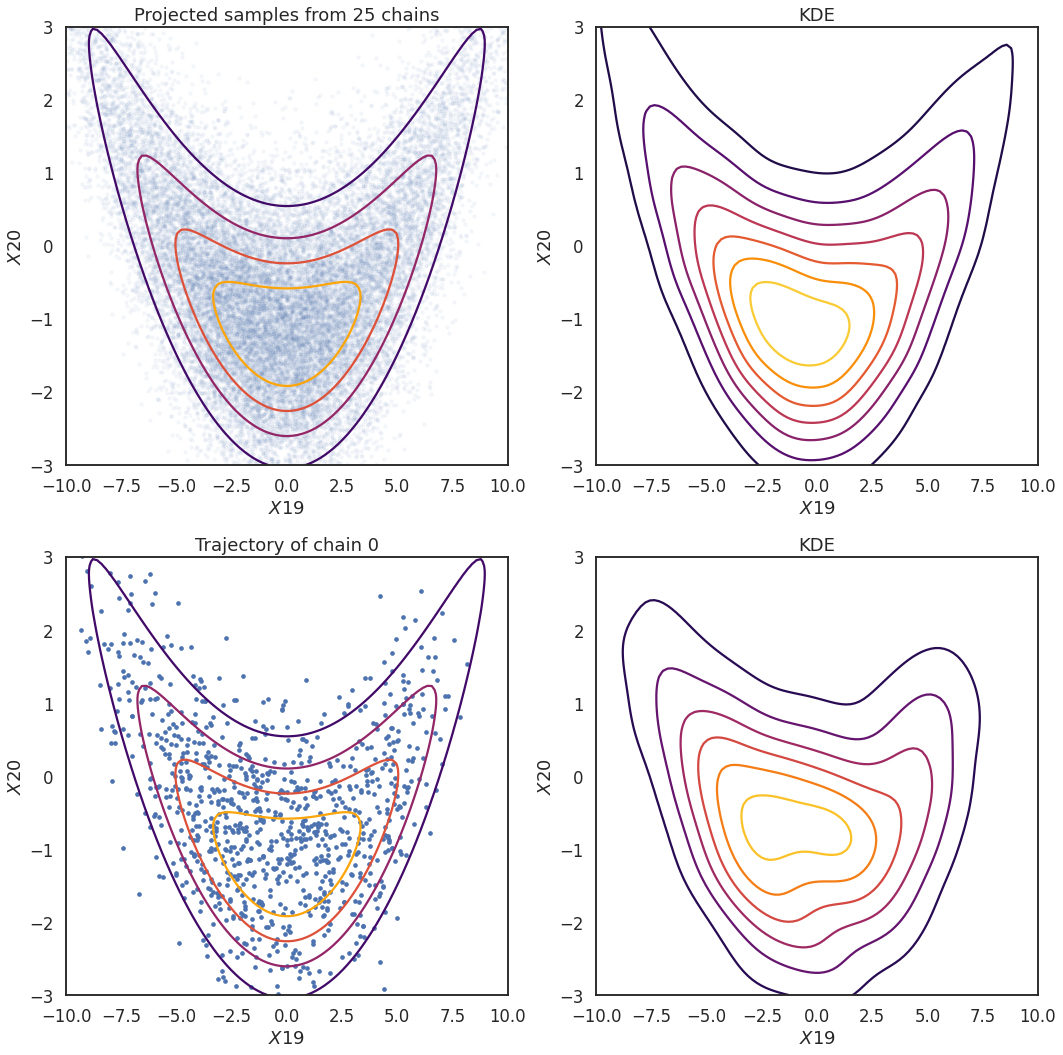

In [ ]:
plot_result(chains, banana)

Now we will switch to HMC and its popular modifications (NUTS).

In [ ]:
def sample_HMC(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        n_leap_steps: int,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_leap_steps - number of leapfrog steps
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = HMC(
        potential_fn=energy, step_size=step_size, num_steps=n_leap_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

In [ ]:
def sample_NUTS(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        verbose: bool = False) -> torch.FloatTensor:
    """
    No U-turn sampler
    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = NUTS(potential_fn=energy, full_mass=False)
    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

In [ ]:
dim = 10
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)

#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#hyperparameters for HMC
step_size = 0.1
n_leap_steps = 30 #choose different number of leap-frog steps: N = 5, 30, 50

chains = sample_HMC(start_mog, mog, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:15, 71.69it/s, step size=2.33e-01, acc. prob=0.893]


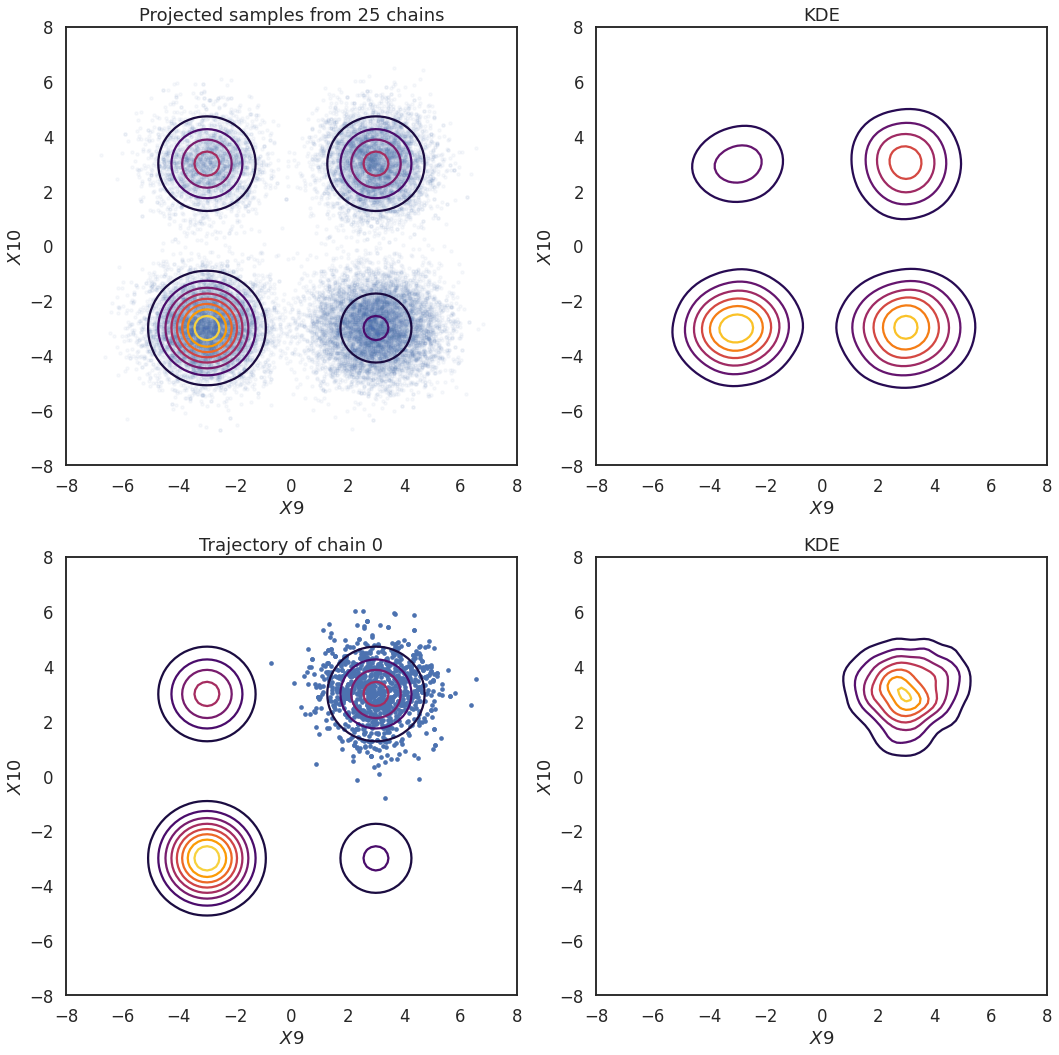

In [ ]:
plot_result(chains, mog)

In [ ]:
step_size = 0.1
n_leap_steps = 50 #choose different values: N = 5, 10, 50

chains = sample_HMC(start_banana, banana, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:34, 31.73it/s, step size=8.83e-02, acc. prob=0.874]


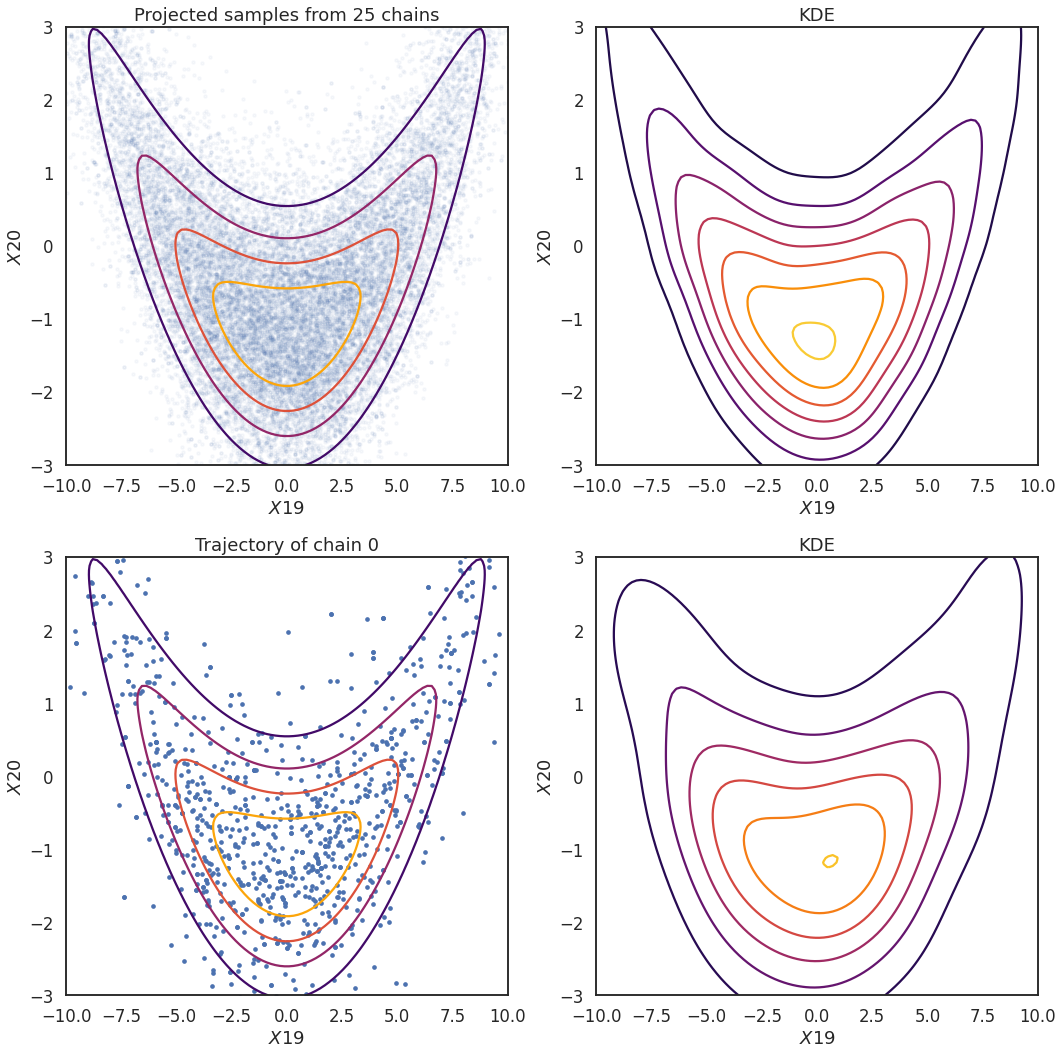

In [ ]:
plot_result(chains, banana)

In [ ]:
step_size = 0.1
n_leap_steps = 20 #try different ones: L = 10, 20, 50

chains = sample_HMC(start_funnel, funnel, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:43, 25.53it/s, step size=2.67e-02, acc. prob=0.933]


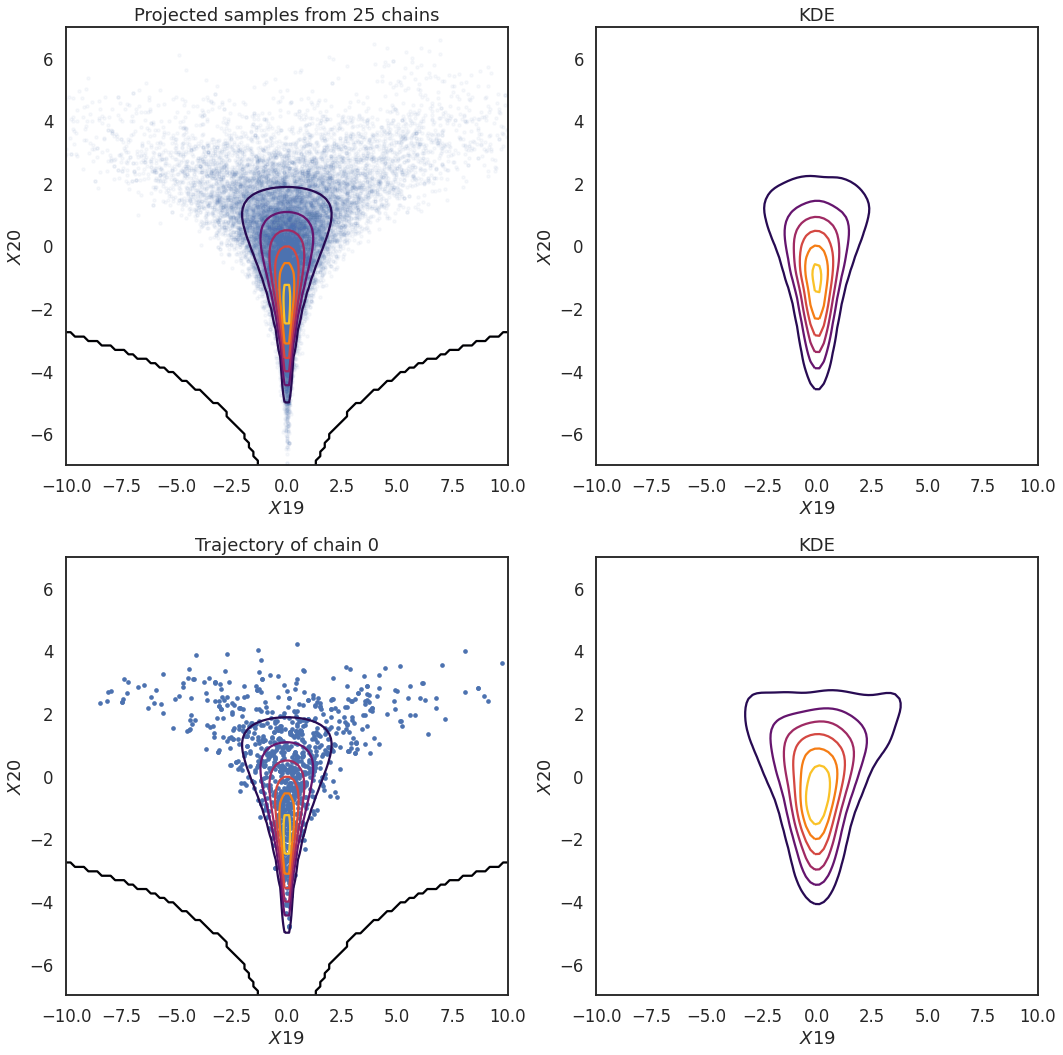

In [ ]:
plot_result(chains, funnel)

Now let us try NUTS - the HMC method with balanced strategy for fine-tuning stepsize $\varepsilon$ and the number of steps $L$

In [ ]:
dim = 2
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)
#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#hyperparameters for HMC
#finally no hyperparameters!

chains = sample_NUTS(start_mog, mog, N_SAMPLES, BURN_IN,verbose=True)

Sample: 100%|██████████| 1100/1100 [00:42, 25.86it/s, step size=2.01e-01, acc. prob=0.912]


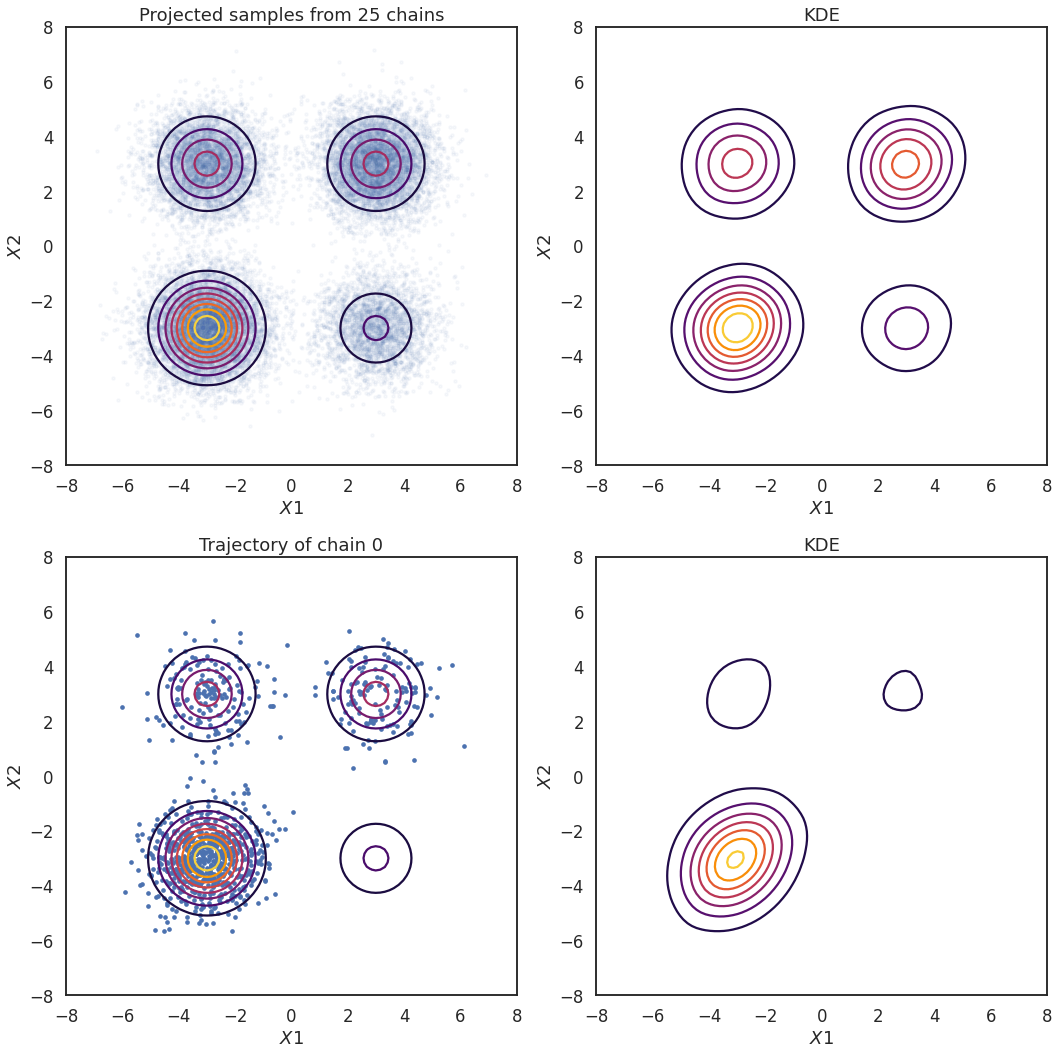

In [ ]:
plot_result(chains, mog)